# SYS 611: SimPy Queuing System

Paul T. Grogan <pgrogan@stevens.edu>

This example creates a queuing system simulation in SimPy using two types of servers: human and kiosks. After arriving, customers request the first available server. Each server has its own service rate.

## Dependencies

This example is compatible with Python 2 environments through use of the `__future__` library function. Additionally, this example uses the `numpy`, `matplotlib.pyplot` and `simpy` libraries. SimPy is not a standard library included in most Python distributions. The `!pip install simpy` command below attempts to install it using the pip package management system.

In [1]:
# import the python3 behavior for importing, division, and printing in python2
from __future__ import absolute_import, division, print_function

# import the numpy package and refer to it as `np`
import numpy as np

# import the matplotlib pyplot package and refer to it as `plt`
import matplotlib.pyplot as plt

!pip install simpy

# import the simpy package
import simpy

## Simulation Model

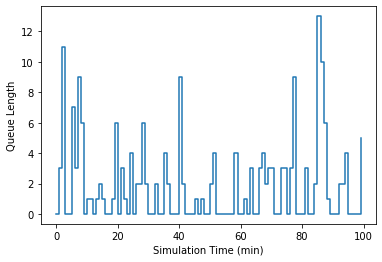

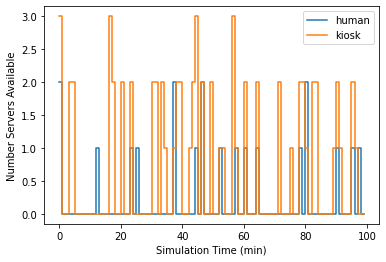

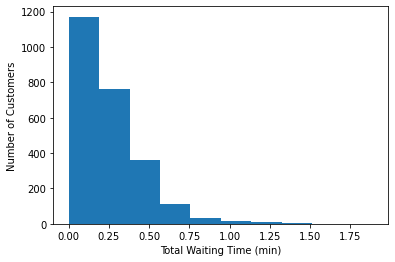

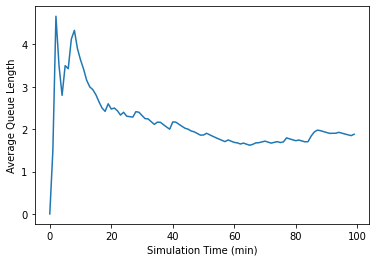

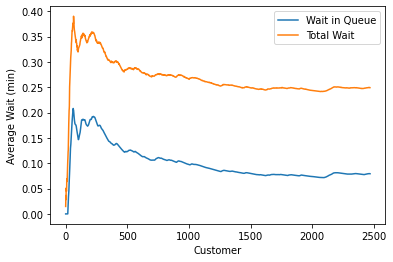

In [38]:
def cafe_run(env, human_servers, kiosk_servers, _lambda, _mu_human, _mu_kiosk):
    """ Process for simulating a cafe.

    Args:
        env (simpy.Environment): the simulation environment
        human_servers (simpy.Resource): the human servers resource
        kiosk_servers (simpy.Resource): the kiosk servers resource
        _lambda (float): the average inter-arrival rate (customers/minute)
        _mu_human (float): the average human service rate (customers/minute)
        _mu_kiosk (float): the average kiosk service rate (customers/minute)
    """
    while True:
        # wait for the next arrival
        yield env.timeout(np.random.exponential(1/_lambda))
        # launch the customer process
        env.process(handle_customer(env, human_servers, kiosk_servers, _mu_human, _mu_kiosk))

def handle_customer(env, human_servers, kiosk_servers, _mu_human, _mu_kiosk):
    """ Process for simulating a customer.

    Args:
        env (simpy.Environment): the simulation environment
        human_servers (simpy.Resource): the human servers resource
        kiosk_servers (simpy.Resource): the kiosk servers resource
        _mu_human (float): the average human service rate (customers/minute)
        _mu_kiosk (float): the average kiosk service rate (customers/minute)
    """
    # make requests to both types of servers
    human_request = human_servers.request()
    kiosk_request = kiosk_servers.request()
    arrival_time = env.now
    # wait to get the first available server
    yield human_request | kiosk_request
    # release or cancel second request
    if human_request.usage_since:
      if kiosk_request.usage_since:
        kiosk_servers.release(kiosk_request)
      else:
        kiosk_request.cancel()
    else:
      if human_request.usage_since:
        human_request.release(kiosk_request)
      else:
        human_request.cancel()
    service_time = env.now
    wait_queue.append(service_time - arrival_time)
    # wait for the service to complete
    if human_request.usage_since:
      yield env.timeout(np.random.exponential(1/_mu_human))
    else:
      yield env.timeout(np.random.exponential(1/_mu_kiosk))
    depart_time = env.now
    wait_total.append(depart_time - arrival_time)
    # release server
    if human_request.usage_since:
      human_servers.release(human_request)
    else:
      kiosk_servers.release(kiosk_request)

def observe(env, human_servers, kiosk_servers):
    """ Process to observe the queue length during a simulation.

    Args:
        env (simpy.Environment): the simulation environment
        servers (simpy.Resource): the servers resource
    """
    while True:
        # record the observation time and queue length
        obs_time.append(env.now)
        obs_length_queue.append(len(human_servers.queue))
        obs_servers_human.append(human_servers.capacity - human_servers.count)
        obs_servers_kiosk.append(kiosk_servers.capacity - kiosk_servers.count)
        # wait for the next minute
        yield env.timeout(1.0)

# create the simulation environment
env = simpy.Environment()

# create arrays to record data
wait_queue = []
wait_total = []
obs_time = []
obs_length_queue = []
obs_servers_human = []
obs_servers_kiosk = []

# create the servers resource
human_servers = simpy.Resource(env, capacity=2)
kiosk_servers = simpy.Resource(env, capacity=3)

# add the cafe process
env.process(cafe_run(env, human_servers, kiosk_servers, 25.0, 4.0, 7.0))
# add the observation process
env.process(observe(env, human_servers, kiosk_servers))
# run the simulation for 100 minutes
env.run(until=100)

# create a plot showing the queue length at each time
plt.figure()
plt.step(obs_time, obs_length_queue, where='post')
plt.xlabel('Simulation Time (min)')
plt.ylabel('Queue Length')
plt.show()

# create a plot showing the number of servers available at each time
plt.figure()
plt.step(obs_time, obs_servers_human, where='post', label="human")
plt.step(obs_time, obs_servers_kiosk, where='post', label="kiosk")
plt.xlabel('Simulation Time (min)')
plt.ylabel('Number Servers Available')
plt.legend()
plt.show()

# create a plot showing the histogram of waiting time
plt.figure()
plt.hist(wait_total)
plt.xlabel('Total Waiting Time (min)')
plt.ylabel('Number of Customers')
plt.show()

# create a plot showing the average queue length at each time
plt.figure()
plt.plot(obs_time, np.cumsum(obs_length_queue)/np.arange(1, 1+len(obs_length_queue)))
plt.xlabel('Simulation Time (min)')
plt.ylabel('Average Queue Length')
plt.show()

# create a plot showing the average wait time (queue and total) at each time
plt.figure()
plt.plot(1+np.arange(len(wait_queue)), np.cumsum(wait_queue)/np.arange(1, 1+len(wait_queue)), label='Wait in Queue')
plt.plot(1+np.arange(len(wait_total)), np.cumsum(wait_total)/np.arange(1, 1+len(wait_total)), label='Total Wait')
plt.xlabel('Customer')
plt.ylabel('Average Wait (min)')
plt.legend()
plt.show()

## Monte Carlo Simulation

In [39]:
NUM_RUNS = 10

# array to store outputs
AVERAGE_WAIT = []

for i in range(NUM_RUNS):
    # set the initial seed
    np.random.seed(i)

    # create the simulation environment
    env = simpy.Environment()

    # create arrays to record data
    wait_queue = []
    wait_total = []
    obs_time = []
    obs_length_queue = []
    obs_servers_human = []
    obs_servers_kiosk = []

    # create the servers resource
    human_servers = simpy.Resource(env, capacity=2)
    kiosk_servers = simpy.Resource(env, capacity=3)
    # add the cafe process
    env.process(cafe_run(env, human_servers, kiosk_servers, 25.0, 4.0, 7.0))
    # add the observation process
    env.process(observe(env, human_servers, kiosk_servers))
    # run the simulation
    env.run(until=100)
    
    # record the final average waiting time
    AVERAGE_WAIT.append(np.mean(wait_total))

# print final results to console
print('Average waiting time for N={:} runs:'.format(NUM_RUNS))
print('\n'.join('{:.2f}'.format(i) for i in AVERAGE_WAIT))

# write results to CSV file
import csv

with open('queuing.csv', 'w') as output:
    writer = csv.writer(output)
    writer.writerow(['Run', 'Avg. Total Waiting Time'])
    for i, sample in enumerate(AVERAGE_WAIT):
        writer.writerow([i+1, sample])

Average waiting time for N=10 runs:
0.32
0.39
0.25
0.36
0.37
0.26
0.28
0.31
0.36
0.30
